In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data_utils
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data import Dataset
from torch.utils import data
import pandas as pd
import numpy as np
from torch.autograd import Variable, grad
from sklearn.preprocessing import LabelEncoder,StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import random_split
from sklearn.metrics import roc_curve, roc_auc_score, precision_score, confusion_matrix

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class PatientDataset(Dataset):
    def __init__(self, data, labels):
      """
      Args:
          data: Features(patient by gene matrix)
          labels: Labels(0 for real,1 for synthetic)
      """
      self.data = torch.tensor(data, dtype=torch.float32)
      self.labels =torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
      return len(self.data)

    def __getitem__(self, idx):
      return self.data[idx], self.labels[idx]

In [ ]:
synthetic_data_path="/content/drive/My Drive/Colab Notebooks/syn_304_128_0.00001.csv"
synthetics=pd.read_csv(synthetic_data_path)
synthetics.to_csv("/content/drive/My Drive/Colab Notebooks/synthetics.csv")

In [ ]:
#d=pd.read_csv("/content/drive/My Drive/Colab Notebooks/synthetics.csv",index_col=0)
#d

In [ ]:
def load_data(real_data_path, synthetic_data_path):

     real_data = pd.read_csv(real_data_path,index_col=0)
     X_real = real_data.iloc[:, :-1].values #featues
     y_real = np.zeros(len(X_real))  #label 0 for real

     synthetic_data = pd.read_csv(synthetic_data_path,index_col=0)
     #print(synthetic_data)
     X_synthetic = synthetic_data.iloc[:, :-1].values #featues
     y_synthetic = np.ones(len(X_synthetic)) #label 1 for synthetic

     #print(f"Shape of X_real: {X_real.shape}")
     #print(f"Shape of X_synthetic: {X_synthetic.shape}")

     X_combined=np.vstack((X_real, X_synthetic))
     y_combined=np.hstack((y_real, y_synthetic))

     return X_combined, y_combined

real_data_path="/content/drive/My Drive/Colab Notebooks/final_304.csv"
synthetic_data_path="/content/drive/My Drive/Colab Notebooks/synthetics.csv"

X_combined, y_combined = load_data(real_data_path, synthetic_data_path)

In [ ]:
#X_combined,y_combined


In [ ]:
dataset = PatientDataset(X_combined, y_combined)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

#dataloader= DataLoader(dataset, batch_size=32, shuffle=True)


In [ ]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [ ]:
#dataloader

In [ ]:
class Classifier(nn.Module):
     def __init__(self, input_dim):
          super(Classifier, self).__init__()
          self.model = nn.Sequential(
               nn.Linear(input_dim, 256),
               nn.ReLU(),
               nn.Dropout(0.5),
               nn.Linear(256, 128),
               nn.ReLU(),
               nn.Linear(128, 64),
               nn.ReLU(),
               nn.Linear(64, 32),
               nn.ReLU(),
               nn.Linear(32, 1),
               nn.Sigmoid(),
          )
     def forward(self, x):
          return self.model(x)



In [ ]:
input_dim=X_combined.shape[1]
classifier=Classifier(input_dim=input_dim)

In [ ]:
#input_dim

In [ ]:
criterion=nn.BCELoss()
optimizer=optim.Adam(classifier.parameters(), lr=0.000001)

Epoch [1/1000] - Train Loss: 4.0902- Val Loss:1.3917
Epoch [2/1000] - Train Loss: 4.3421- Val Loss:0.9842
Epoch [3/1000] - Train Loss: 4.2534- Val Loss:0.6345
Epoch [4/1000] - Train Loss: 3.9253- Val Loss:0.5705
Epoch [5/1000] - Train Loss: 3.4108- Val Loss:0.5283
Epoch [6/1000] - Train Loss: 2.3742- Val Loss:0.5026
Epoch [7/1000] - Train Loss: 2.6179- Val Loss:0.4936
Epoch [8/1000] - Train Loss: 2.4114- Val Loss:0.4902
Epoch [9/1000] - Train Loss: 2.4466- Val Loss:0.4880
Epoch [10/1000] - Train Loss: 1.9890- Val Loss:0.4861
Epoch [11/1000] - Train Loss: 2.0621- Val Loss:0.4840
Epoch [12/1000] - Train Loss: 1.4553- Val Loss:0.4819
Epoch [13/1000] - Train Loss: 2.1809- Val Loss:0.4791
Epoch [14/1000] - Train Loss: 2.1015- Val Loss:0.4759
Epoch [15/1000] - Train Loss: 0.8262- Val Loss:0.4725
Epoch [16/1000] - Train Loss: 1.3153- Val Loss:0.4699
Epoch [17/1000] - Train Loss: 1.1372- Val Loss:0.4671
Epoch [18/1000] - Train Loss: 1.3955- Val Loss:0.4639
Epoch [19/1000] - Train Loss: 1.8670-

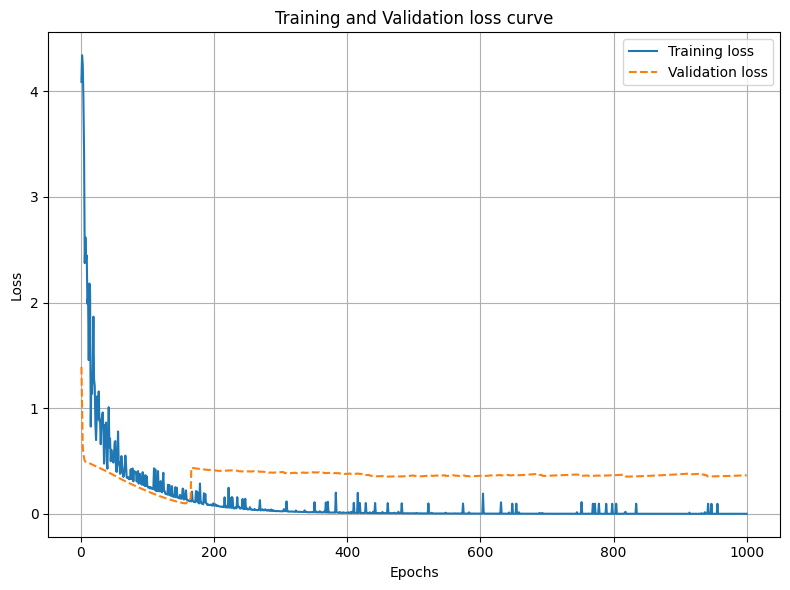

In [ ]:
epochs=1000
train_losses=[]
val_losses=[]

for epoch in range(epochs):
    classifier.train()
    train_loss=0.0

    for features, labels in train_loader:
        optimizer.zero_grad()

        #forward pass
        predictions=classifier(features)
        predictions=predictions.view(-1)
        loss=criterion(predictions, labels)

        #backward pass
        loss.backward()
        optimizer.step()

        train_loss+=loss.item()

    #avg_epoch_loss=epoch_loss/len(dataloader)
    train_losses.append(train_loss/len(train_loader))

    #validation
    classifier.eval()
    val_loss=0.0

    with torch.no_grad():
        for features, labels in val_loader:
            predictions=classifier(features).squeeze()
            loss=criterion(predictions, labels)
            val_loss+=loss.item()

    val_losses.append(val_loss/len(val_loader))
    print(f"Epoch [{epoch+1}/{epochs}] - Train Loss: {train_loss/len(train_loader):.4f}- Val Loss:{val_loss/len(val_loader):.4f}")

torch.save(classifier.state_dict(), "real_vs_synthetic_classifier_with_val.pth")


plt.figure(figsize=(8,6))
plt.plot(range(1,epochs+1),train_losses,label='Training loss')
plt.plot(range(1,epochs+1),val_losses,label='Validation loss',linestyle='--')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation loss curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



In [ ]:
#torch.save(classifier.state_dict(), "real_vs_synthetic_classifier.pth")
#print("classifier saved successfully")

In [ ]:
#model=torch.load("real_vs_synthetic_classifier.pth")
#model

In [ ]:
#test the classifier on val data
def test_classifier(classifier, data_loader):
    classifier.eval()
    correct=0
    total=0
    with torch.no_grad():
        for features, labels in data_loader:
            predictions=classifier(features).squeeze()
            predictions=(predictions>0.5).float()

            correct+=(predictions==labels).sum().item()
            total+=labels.size(0)
    accuracy=correct/total
    return accuracy

#evaluate classifier on validation set
val_accuracy=test_classifier(classifier,val_loader)
print(f"validation Accuracy: {val_accuracy:.4f}")

#test_classifier(classifier, X_combined,y_combined)

validation Accuracy: 0.9923


Precision: 0.9900
ROC AUC: 0.9841
Specificity: 0.9683
 correctly predicted IBD: 198, incorrectly predicted IBD: 2
 correctly predicted non-IBD: 61, incorrectly predicted non-IBD: 0


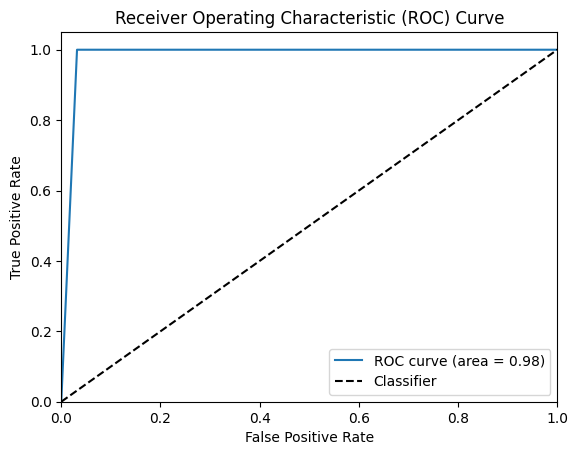

In [ ]:
classifier.eval()

all_labels=[]
all_predictions=[]

with torch.no_grad():
    for features, labels in val_loader:
        predictions=classifier(features)
        predictions=(predictions>0.5).float()
        all_labels.extend(labels.numpy())
        all_predictions.extend(predictions.numpy())

all_labels=np.array(all_labels)
all_predictions=np.array(all_predictions)

precision=precision_score(all_labels, all_predictions.round())
roc_auc=roc_auc_score(all_labels, all_predictions)
fpr, tpr, _ =roc_curve(all_labels, all_predictions)

tn, fp, fn, tp = confusion_matrix(all_labels, all_predictions.round()).ravel()
specificity=tn/(tn+fp)

print(f"Precision: {precision:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f" correctly predicted IBD: {tp}, incorrectly predicted IBD: {fp}")
print(f" correctly predicted non-IBD: {tn}, incorrectly predicted non-IBD: {fn}")

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.show()


In [ ]:
def extract_marker_genes(classifier,gene_names):

    first_layer=classifier.model[0]
    weights=first_layer.weight.data.cpu().numpy().squeeze()
    #compute the absolute mean  weight for each gene across all nodes in the hidden layer
    gene_importance=np.mean(np.abs(weights),axis=0)

    if isinstance(gene_names, pd.Index):
        gene_names = gene_names.tolist()

    min_len = min(len(gene_names), len(gene_importance))
    gene_names = gene_names[:min_len]
    gene_importance = gene_importance[:min_len ]
    gene_df=pd.DataFrame({"Gene":gene_names,"Importance":gene_importance})
    gene_df=gene_df.sort_values(by="Importance",ascending=False)
    return gene_df

In [ ]:
#real_data=pd.read_csv(real_data_path,index_col=0)
#gene_names=real_data.columns[:-1]
gene_names=pd.read_csv(real_data_path).columns[:-1]

In [ ]:
marker_genes=extract_marker_genes(classifier,gene_names)

In [ ]:
top_50=marker_genes[:50]

In [ ]:
print(marker_genes.head(10))

         Gene  Importance
287     CSF3R    0.015830
498     GNA15    0.015554
988    RNF141    0.015211
231    CLDN12    0.015207
1062  SLC16A2    0.015206
569    IFI44L    0.015189
717       LPL    0.015045
1098   SMIM19    0.015041
224    CHRDL2    0.015035
603     IL12A    0.015005


In [ ]:
top_50.to_csv("/content/drive/My Drive/Colab Notebooks/203_128_0.00001_marker_genes_0.000001adam.csv",index=False)


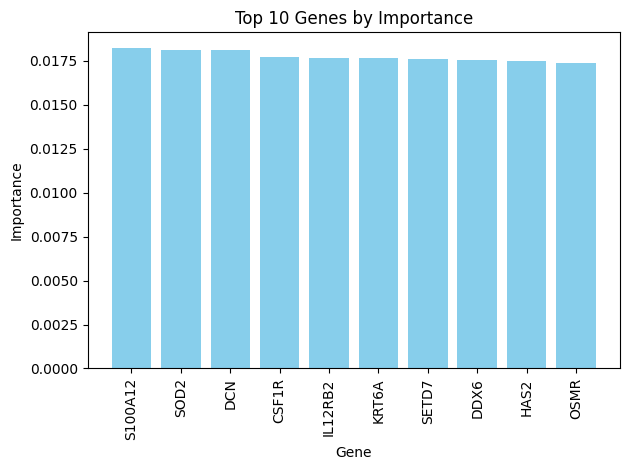

In [ ]:
import matplotlib.pyplot as plt
df_sorted=marker_genes.sort_values(by="Importance",ascending=False)
top_genes=df_sorted.head(10)

plt.bar(top_genes["Gene"],top_genes["Importance"],color='skyblue')
plt.xlabel("Gene")
plt.ylabel("Importance")
plt.title("Top 10 Genes by Importance")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()